In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
#---------------------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator



from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import EfficientNetB2



#---------------------------------------
import warnings
warnings.filterwarnings("ignore")

C:\Users\Asus\anaconda3\envs\venv\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def train_df(tr_path):
    classes = []
    class_paths = []
    files = os.listdir(tr_path)
    for file in files:
        label_dir = os.path.join(tr_path, file)
        label = os.listdir(label_dir)
        for image in label:
            image_path = os.path.join(label_dir, image)
            class_paths.append(image_path)
            classes.append(file)
    image_classes = pd.Series(classes, name='Class')
    image_paths = pd.Series(class_paths, name='Class Path')
    tr_df = pd.concat([image_paths, image_classes], axis=1)
    return tr_df

In [3]:
def test_df(ts_path):
    classes = []
    class_paths = []
    files = os.listdir(ts_path)
    for file in files:
        label_dir = os.path.join(ts_path, file)
        label = os.listdir(label_dir)
        for image in label:
            image_path = os.path.join(label_dir, image)
            class_paths.append(image_path)
            classes.append(file)
    image_classes = pd.Series(classes, name='Class')
    image_paths = pd.Series(class_paths, name='Class Path')
    ts_df = pd.concat([image_paths, image_classes], axis=1)
    return ts_df

In [4]:
tr_df = train_df('Training')

In [5]:
tr_df

,Class Path,Class
0,Training\glioma\Tr-glTr_0000.jpg,glioma
1,Training\glioma\Tr-glTr_0001.jpg,glioma
2,Training\glioma\Tr-glTr_0002.jpg,glioma
3,Training\glioma\Tr-glTr_0003.jpg,glioma
4,Training\glioma\Tr-glTr_0004.jpg,glioma
...,...,...
5707,Training\pituitary\Tr-pi_1452.jpg,pituitary
5708,Training\pituitary\Tr-pi_1453.jpg,pituitary
5709,Training\pituitary\Tr-pi_1454.jpg,pituitary
5710,Training\pituitary\Tr-pi_1455.jpg,pituitary


In [6]:
ts_df = test_df('Testing')

In [7]:
ts_df

,Class Path,Class
0,Testing\glioma\Te-glTr_0000.jpg,glioma
1,Testing\glioma\Te-glTr_0001.jpg,glioma
2,Testing\glioma\Te-glTr_0002.jpg,glioma
3,Testing\glioma\Te-glTr_0003.jpg,glioma
4,Testing\glioma\Te-glTr_0004.jpg,glioma
...,...,...
1305,Testing\pituitary\Te-pi_0295.jpg,pituitary
1306,Testing\pituitary\Te-pi_0296.jpg,pituitary
1307,Testing\pituitary\Te-pi_0297.jpg,pituitary
1308,Testing\pituitary\Te-pi_0298.jpg,pituitary


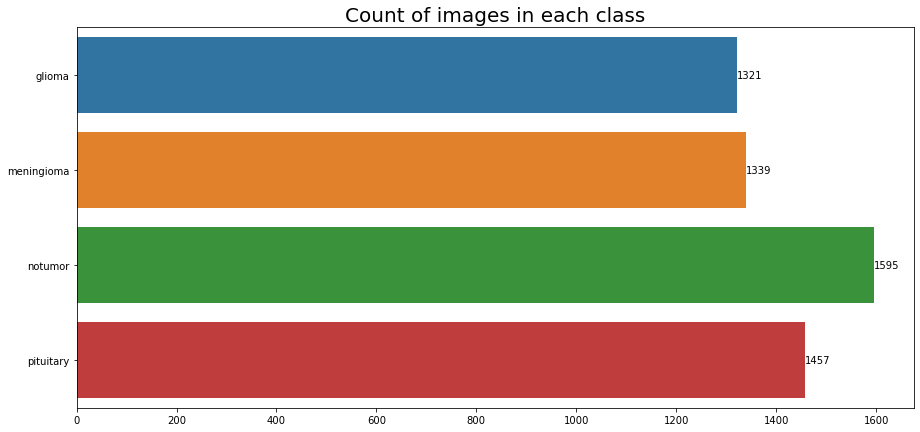

In [8]:
# Count of images in each class
plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df , y=tr_df['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

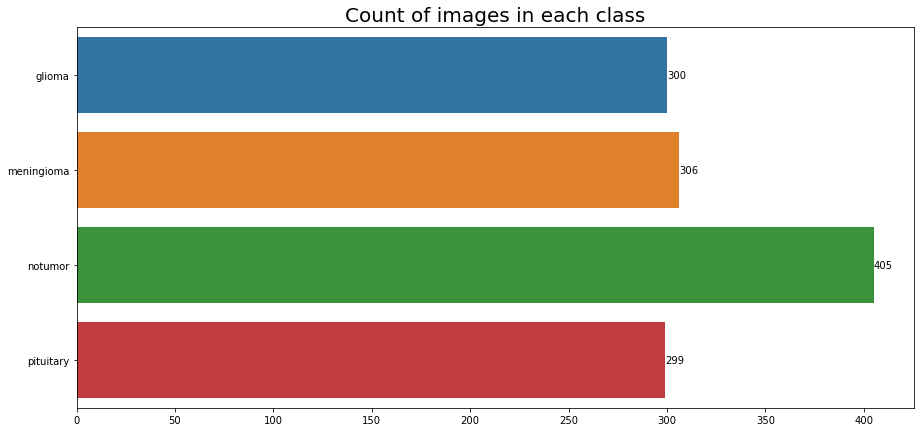

In [9]:
# Count of images in each class
plt.figure(figsize=(15,7))
ax = sns.countplot(data=ts_df , y=ts_df['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

In [10]:
valid_df, ts_df = train_test_split(ts_df, train_size=.5, random_state=20)

In [11]:
valid_df

,Class Path,Class
464,Testing\meningioma\Te-me_0164.jpg,meningioma
987,Testing\notumor\Te-no_0381.jpg,notumor
565,Testing\meningioma\Te-me_0265.jpg,meningioma
503,Testing\meningioma\Te-me_0203.jpg,meningioma
502,Testing\meningioma\Te-me_0202.jpg,meningioma
...,...,...
1242,Testing\pituitary\Te-pi_0232.jpg,pituitary
924,Testing\notumor\Te-no_0318.jpg,notumor
1247,Testing\pituitary\Te-pi_0237.jpg,pituitary
271,Testing\glioma\Te-gl_0271.jpg,glioma


In [12]:
batch_size = 16
img_size = (299,299)

tr_gen = ImageDataGenerator(brightness_range=(.8,1.2))

gen = ImageDataGenerator()


tr_gen = tr_gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                 y_col='Class',batch_size=batch_size,
                                 target_size=img_size)

valid_gen = gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                    y_col='Class',batch_size=batch_size,
                                    target_size=img_size)

ts_gen = gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                y_col='Class',batch_size=batch_size,
                                 target_size=img_size,shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.


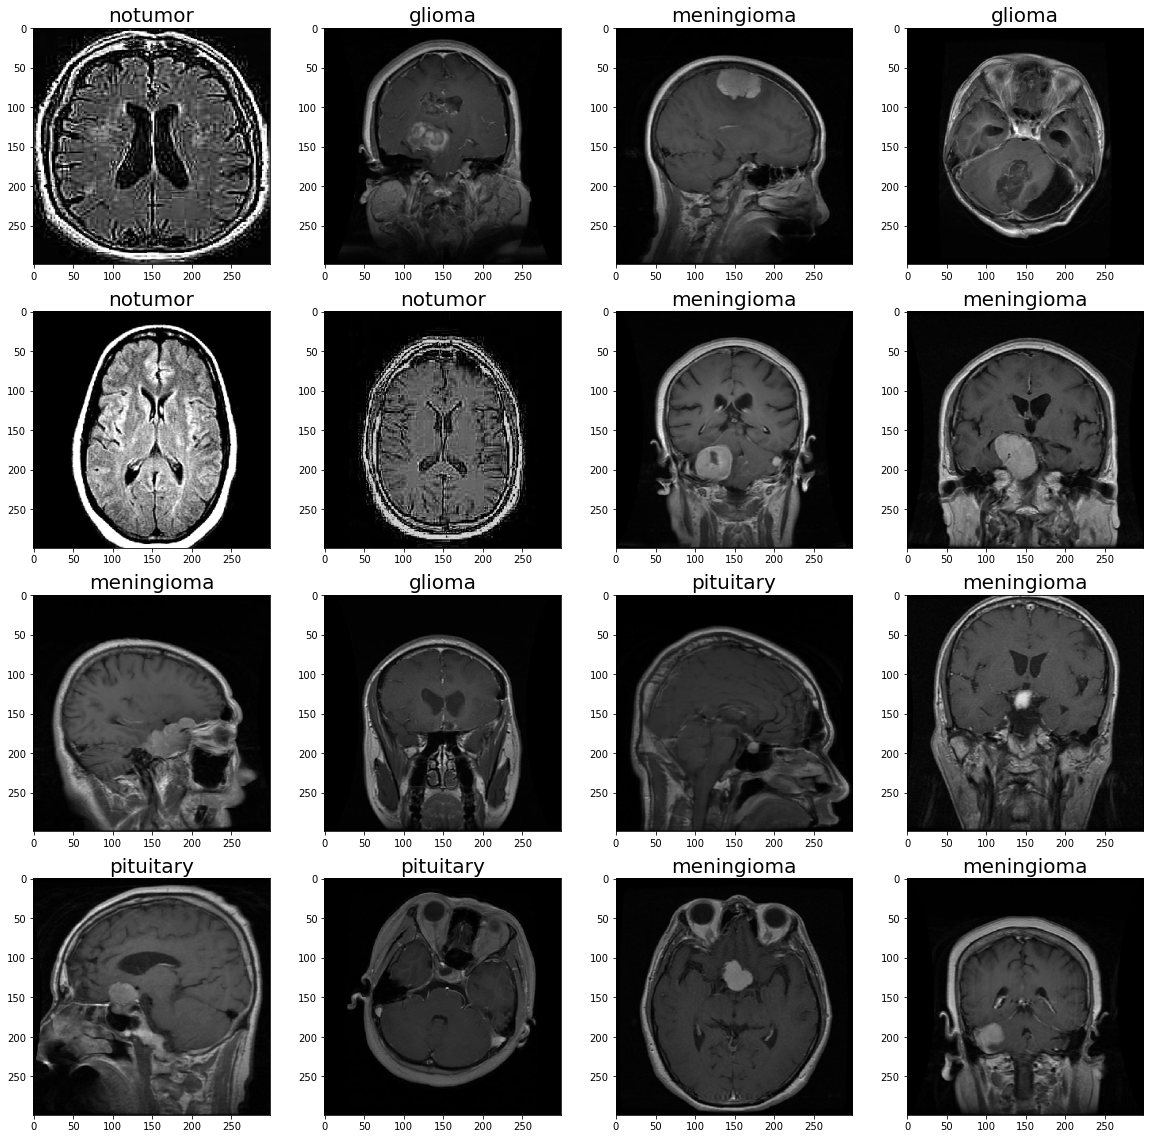

In [13]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(tr_gen)

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color='k', fontsize=20)
plt.show()

In [14]:
img_shape=(299,299,3)
base_model = EfficientNetB2(include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')


# for layer in base_model.layers:
#     layer.trainable = False
    
model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate= 0.3),
    Dense(64, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

model.summary()



31790344/31790344 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional  (None, 1408)              7768569   
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1408)              0         
                                                                 
 dropout (Dropout)           (None, 1408)              0         
                                                                 
 dense (Dense)               (None, 64)                90176     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 

In [15]:
hist = model.fit(tr_gen,
                 epochs=10,
                 validation_data=valid_gen,
                 shuffle= False)

Epoch 1/10


357/357 [==============================] - 1001s 3s/step - loss: 0.6152 - accuracy: 0.8272 - precision: 0.8522 - recall: 0.8046 - val_loss: 0.2255 - val_accuracy: 0.9038 - val_precision: 0.9186 - val_recall: 0.8962
Epoch 2/10
357/357 [==============================] - 939s 3s/step - loss: 0.2025 - accuracy: 0.9286 - precision: 0.9375 - recall: 0.9212 - val_loss: 0.0862 - val_accuracy: 0.9664 - val_precision: 0.9678 - val_recall: 0.9634
Epoch 3/10
357/357 [==============================] - 938s 3s/step - loss: 0.1302 - accuracy: 0.9575 - precision: 0.9613 - recall: 0.9520 - val_loss: 0.0665 - val_accuracy: 0.9878 - val_precision: 0.9892 - val_recall: 0.9832
Epoch 4/10
357/357 [==============================] - 934s 3s/step - loss: 0.0903 - accuracy: 0.9692 - precision: 0.9727 - recall: 0.9662 - val_loss: 0.0401 - val_accuracy: 0.9924 - val_precision: 0.9924 - val_recall: 0.9908
Epoch 5/10
357/357 [==============================] - 935s 3s/step - loss: 0.0794 - accuracy: 0.9

In [16]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

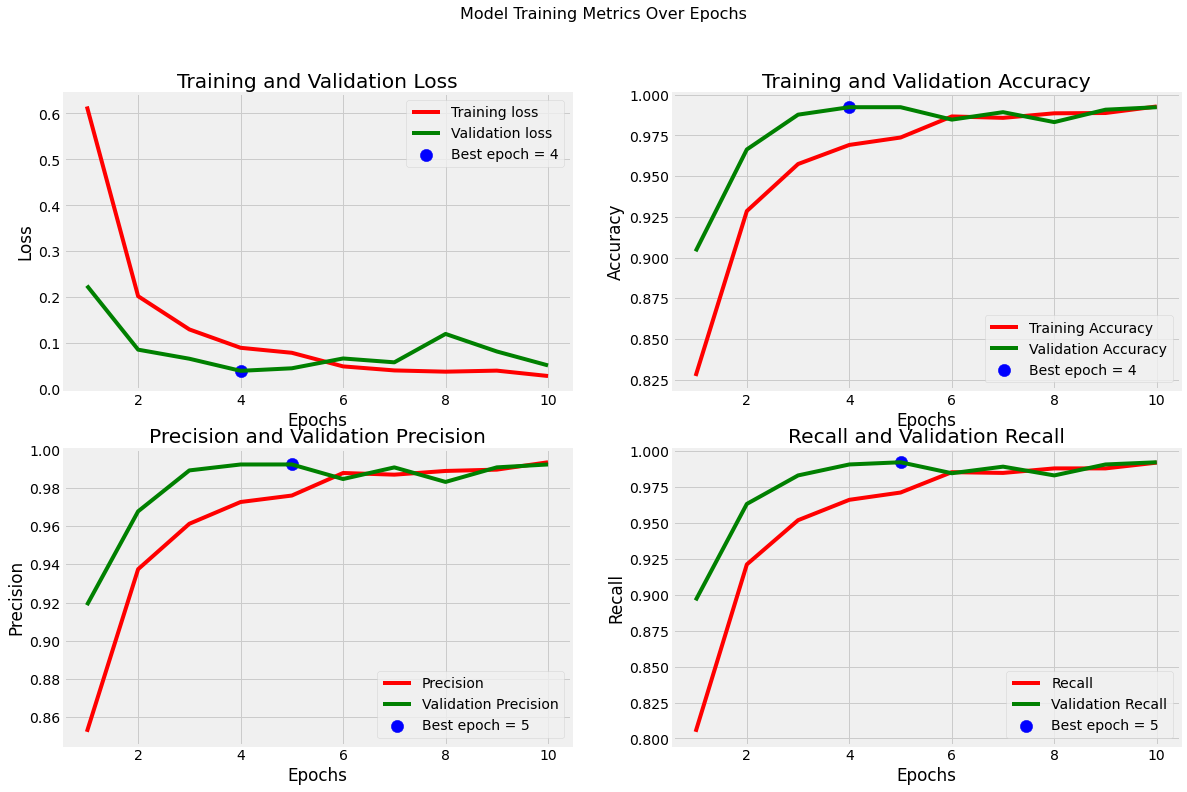

In [17]:
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision']
tr_recall = hist.history['recall']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision']
val_recall = hist.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()


In [18]:
train_score = model.evaluate(tr_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(ts_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

41/41 [==============================] - 24s 577ms/step - loss: 0.0119 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969
Train Loss:  0.002534600906074047
Train Accuracy:  0.9996498823165894
--------------------
Validation Loss:  0.05190518870949745
Validation Accuracy:  0.9923664331436157
--------------------
Test Loss:  0.011865214444696903
Test Accuracy:  0.9969465732574463


In [19]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

41/41 [==============================] - 26s 588ms/step


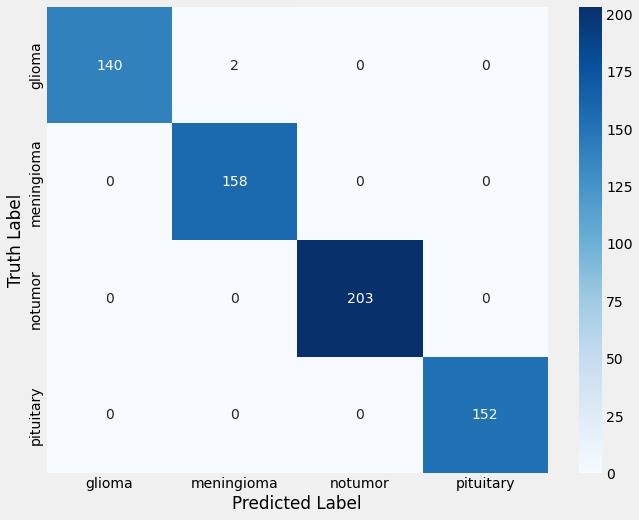

In [20]:
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [21]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       142
           1       0.99      1.00      0.99       158
           2       1.00      1.00      1.00       203
           3       1.00      1.00      1.00       152

    accuracy                           1.00       655
   macro avg       1.00      1.00      1.00       655
weighted avg       1.00      1.00      1.00       655



In [22]:
def predict(img_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    label = list(class_dict.keys())
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    resized_img = img.resize((299, 299))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    predictions = model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

1/1 [==============================] - 2s 2s/step


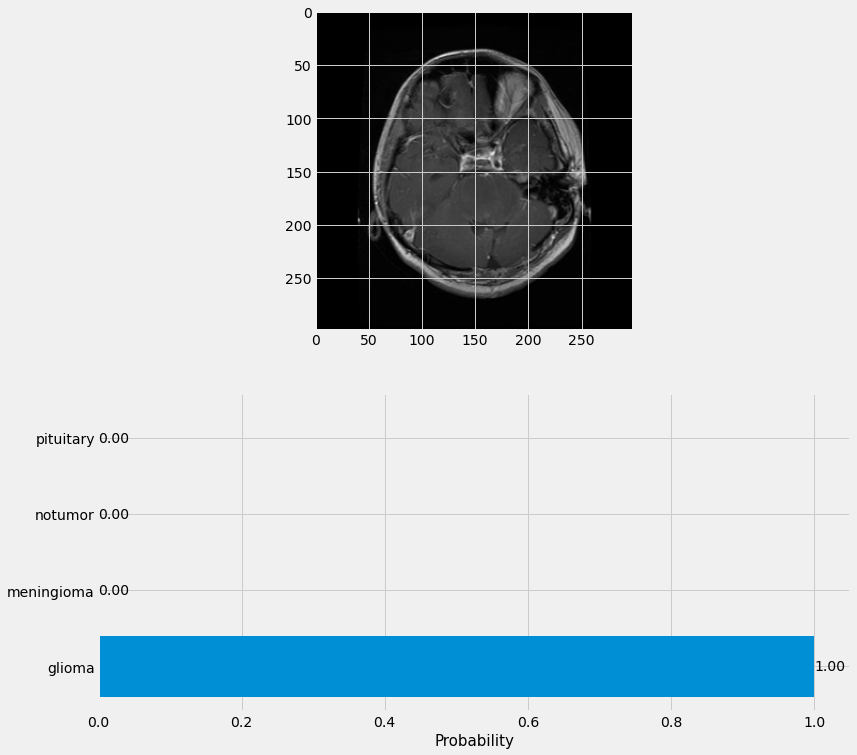

In [23]:
predict('Testing/glioma/Te-gl_0010.jpg')

In [24]:
model.save("brain_tumor_model(EfficientNetB2).h5")